# Klasyfikacja tweetów Elona Muska

### Projekt realizuje grupa:

*  Wiktor Bajor **249459**
*  Adam Kubiak **249480**


### Opis wykonywanego zadania: 

&nbsp; W ramach projektu grupa będzie realizować zadanie klasyfikacji binarnej tweetów Elona Muska. Wykonywane zadanie będzie opierać się o zebranie tweetów sławnych ludzi, takich jak politycy, przedsiębiorcy, sportowcy, celebryci, influencerzy oraz Elon Musk. 
Akwizycja danych będzie realizowana poprzez publiczny interfejs programowania aplikacji (API), udostępniony przez Twitter.  Przy czym możliwa ilość tweetów do pobrania to pięćset tysięcy, co powinno być wystarczającą ilością danych. Dzięki udostępnionemu API można uzyskać dostęp do takich danych jak, treść publikacji, godzina publikacji, lokalizacja, ilość polubień czy ilość retweetów. Po ukończeniu etapu akwizycji danych kolejnym zadaniem, będzie przeanalizowanie tweetów, mając na uwadze takie elementy jak ilość retweetów, ilość polubień, występowanie pewnych słów kluczowych czy też sentyment umieszczonego tekstu. Na podstawie dokonanej analizy zostaną wybrane najbardziej charakterystyczne cechy tweetów Elona Muska. Ostatnim elementem projektu będzie utworzenie i wytrenowanie (na bazie wcześniej wybranych najbardziej istotny cech) klasyfikatora, który będzie oceniał czy dany tweet był napisany przez Elona Muska czy też nie. Wykonana analiza oraz klasyfikator mogłyby zostać wykorzystane do stworzenia cyfrowego sobowtóra Elona Muska. 

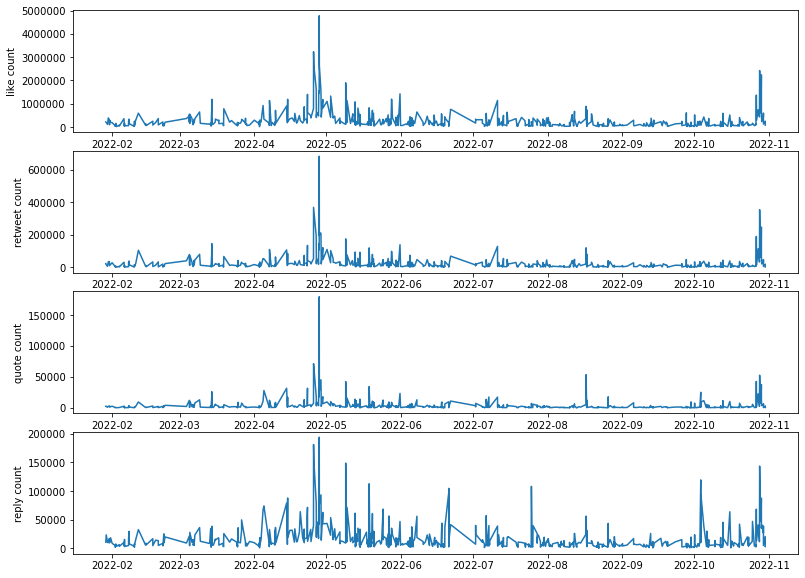

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_charts(data_frame, ylabels):
    fig = plt.figure(figsize=(13,10))
    fig.subplots_adjust(hspace=0.15,wspace=0.01)

    n_row = len(ylabels)
    n_col = 1
    for count, ylabel in enumerate(ylabels):
        ax = fig.add_subplot(n_row, n_col, count+1)
        ax.plot(data_frame["created at"].to_numpy(dtype='datetime64'), data_frame[ylabel].to_numpy())
        ax.set_ylabel(ylabel)
        
data_frame_elon = pd.read_csv('user_data/basic_elonmusk_tweets.csv')
data_frame_elon["created at"] = pd.to_datetime(data_frame_elon["created at"])

ylabels = ["like count","retweet count", 'quote count', 'reply count']


plot_charts(data_frame_elon, ylabels)

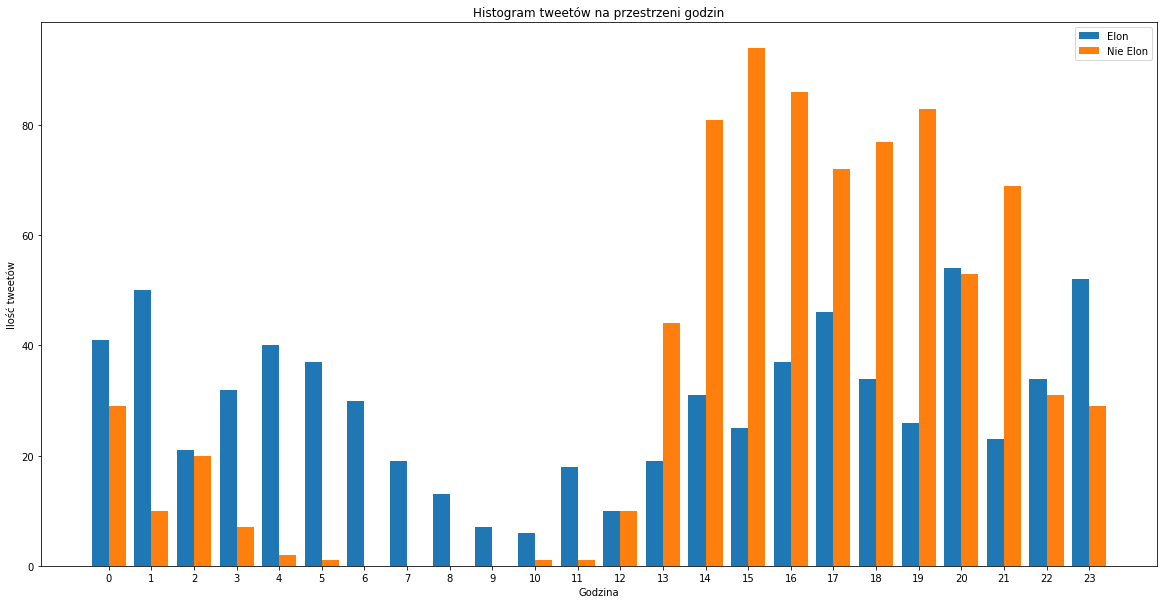

In [19]:
data_frame_obama = pd.read_csv('user_data/basic_BarackObama_tweets.csv')
data_frame_obama["created at"] = pd.to_datetime(data_frame_obama["created at"])

obama_data_count_by_hour = data_frame_obama['created at'].groupby(data_frame_obama['created at'].dt.hour).count()
elon_data_count_by_hour = data_frame_elon['created at'].groupby(data_frame_elon['created at'].dt.hour).count()

def fill_missing_hours_with_zero(data_count_by_hour_dict):
    for i in range(24):
        if i not in data_count_by_hour_dict:
            data_count_by_hour_dict[i] = 0
    
    data_count_by_hour_list = list(dict(sorted(data_count_by_hour_dict.items())).values())
    return np.array(data_count_by_hour_list).astype(float)

data_count_by_hour = fill_missing_hours_with_zero(obama_data_count_by_hour.to_dict())

def plot_histogram_of_tweet_during_time(elon_data_count_by_hour, not_elon_data_count_by_hour):
    bar_width = 0.4
    hours = np.arange(24)
    plt.figure(figsize=(20, 10))
    plt.bar(hours - bar_width/2, elon_data_count_by_hour.values, width=bar_width, label='Elon')
    plt.bar(hours + bar_width/2, not_elon_data_count_by_hour, width=0.4, label='Nie Elon')

    plt.xticks(hours, hours)
    plt.xlabel("Godzina")
    plt.ylabel("Ilość tweetów")
    plt.title("Histogram tweetów na przestrzeni godzin")
    plt.legend()
    plt.show()

plot_histogram_of_tweet_during_time(elon_data_count_by_hour, data_count_by_hour)

In [ ]:
data_frame = pd.read_csv('user_data/basic_BarackObama_tweets.csv')
plot_charts(data_frame, ylabels)